# FLAG multipulses

It checks that SIRENA reconstructed photons are correctly labelled based on ELOWRES vs. SIGNAL and AVG4SD vs. SIGNAL confidence contours.   

For each SIRENA photon, it answers these questions:   
1. Is it a single PRIMARY (dist_to_prev > 1563) BUT it would be flagged as PILED-UP (outside confidence intervals)?   
2. Is is a PILED-UP pulse (in the table of missing or bad-reconstructed photons) BUT it is flagged as SINGLE?   

Photons not considered (not analysed):
* Solitary Pulses that do not have a close previous or posterior partner (< 100 samples). These pulses have not been even simulated in `xifusim` to save resources.
* Pulses reconstructed with OF-length = 8 samples (same as ELOWRES)   
* Pulses classified as SECONDARIES: previous pulse closer than 1563 samples -> diagnostic confidence intervals do not work for them   

PROCEDURE:   
1. Import modules   
2. Read parameters:   
    - location of simulated monochromatic files for diagnostic confidence intervals   
    - width of conf. interval (n_sigmas)   
    - order of the polynomial for the confidence region fit   
    - secondaries definition
3. Confidence areas definition:   
    3.1 Read/Reconstruct monochromatic HR pulses with SIRENA using all the pre-defined filter lengths: get ELOWRES and AVG4SD columns   
    3.2 For each filter length: ELOWRES vs Reconstructed_Calibration_Energy (SIGNAL) -> polynomial fit to confidence region   
    3.3 For each filter length: AVG4SD vs Reconstructed_Calibration_Energy (SIGNAL) -> polynomial fit to confidence region   
4. Run over all the photons in SIRENA files (all simulations for a given flux) and check if there are miss-flagged photons. Add these miss-classifications to a list (for plotting afterwards)   
5. Plot:   
    5.1 confidence intervals for monochromatic simulated pulses (all filter lengths) and residuals plots (data points outside confidence regions)   
    5.2 miss-flagged photons identified in step 4   

   

### Import modules

In [20]:
import ipywidgets as widgets 
%matplotlib widget

import os
import glob
from subprocess import run, PIPE, STDOUT
import tempfile
from astropy.io import fits
import ast
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET
import auxiliary as aux


In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = f"{tmpDir}:{os.environ['PFILES']}"
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]

### Read parameters

In [ ]:
# read xifusim simulated files
#datadir="/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/CEASaclay/October2024"
datadir="/dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles"
simfiles = glob.glob(f"{datadir}/mono*keV_5000p_50x30.fits")
secondary_samples = 1563
verbose = 1
simEnergies = (0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0)
nsigmas = 5 # for confidence interval polyfit
poly_order = 8 # order of polynomial fit

model = "crab"
flux_mcrab_str = "0.50"
filter="nofilt"
focus="infoc"
exposure = 4331
fluxdir = f"/dataj6/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/flux{flux_mcrab_str}mcrab"

## Create confidence contours in diagnostic plots

### Read/create SIRENA monochromatic files   

Read/Reconstruct monochromatic `xifusim` simulated files using all filter lengths in XML file

In [4]:
lib_sirena = f"{datadir}/optimal_filters_6keV_50x30.fits"
assert os.path.exists(lib_sirena), f"{lib_sirena} does not exist"
xml_xifusim = f"{datadir}/config_xifu_50x30_v3_20240917.xml"
assert os.path.exists(xml_xifusim), f"{xml_xifusim} does not exist"
# read filter lengths from XML file: under <reconstruction> tag in filtlen attribute
# Load and parse the XML file
tree = ET.parse(xml_xifusim)
root = tree.getroot()
# Extract all values of "filtlen" attributes
filtlen_values = [elem.attrib["filtlen"] for elem in root.iter() if "filtlen" in elem.attrib]
# convert it to a list of integers
filtlen_values = [int(x) for x in filtlen_values]

In [5]:
# reconstruct simulated files with SIRENA
for oflen in filtlen_values:
    for xifusimfile in simfiles:
        assert os.path.exists(xifusimfile), f"{xifusimfile} does not exist"
        # remove path from filename:
        filename = os.path.basename(xifusimfile)
        # get energy value from xifusim file name
        energy = float(filename.split("_")[0].replace("keV", "").replace("mono", ""))
        reconsfile = f"{datadir}/events_mono{energy}keV_5000p_50x30_of{oflen}.fits"
        if not os.path.exists(reconsfile):
            comm = (f"tesrecons"
                    f" Recordfile={xifusimfile}"
                    f" TesEventFile={reconsfile}"
                    f" LibraryFile={lib_sirena}"
                    f" XMLFile={xml_xifusim}"
                    f" clobber=yes"
                    f" EnergyMethod=OPTFILT"
                    f" OFStrategy=FIXED"
                    f" OFLength={oflen}"
                    f" filtEeV=6000"
                    f" OFNoise=NSD"
            )
            aux.vprint(f"Doing reconstruction for xifusim file {xifusimfile}")
            aux.vprint(f"Running {comm}")
            
            output_tesrecons = run(comm, shell=True, capture_output=True)
            assert output_tesrecons.returncode == 0, f"tesrecons failed to run => {output_tesrecons.stderr.decode()}"
            assert os.path.exists(reconsfile), f"tesrecons did not produce an output file"
        else:
            aux.vprint(f"Reconstructed file {reconsfile} already exists")
reconsfiles = glob.glob(f"singles/events_mono*keV_5000p_50x30_*.fits")
max_photons = aux.get_max_photons(reconsfiles)        

Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles/events_mono7.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles/events_mono5.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles/events_mono10.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles/events_mono9.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles/events_mono3.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/2024_revision/singles/events_mono4.0keV_5000p_50x30_of8192.fits already exists
Reconstructed file /dataj6SIRENA/ceballos/INSTRUMEN/EURECA/TN350_detection/

### Store information of SIRENA reconstruction of monochromatic files   

Save info of columns SIGNAL, ELOWRES and AVG4SD and take also median and stdev values     

In [6]:

# create numpy arrays to store the data
# the first dimension is the energy, the second dimension is the number of photons  
# inititalize the arrays with NaN
SIGNAL_mono = np.full((len(simEnergies),len(filtlen_values),max_photons), np.nan)
ELOWRES_mono = np.full((len(simEnergies), len(filtlen_values),max_photons), np.nan)
DIFFELOWRES_mono = np.full((len(simEnergies), len(filtlen_values),max_photons), np.nan)
AVG4SD_mono = np.full((len(simEnergies), len(filtlen_values),max_photons), np.nan)
medianSIGNAL = np.full((len(simEnergies), len(filtlen_values)), np.nan)
medianELOWRES = np.full((len(simEnergies), len(filtlen_values)), np.nan)
medianDIFFELOWRES = np.full((len(simEnergies), len(filtlen_values)), np.nan)
stdELOWRES = np.full((len(simEnergies), len(filtlen_values)), np.nan)
stdDIFFELOWRES = np.full((len(simEnergies), len(filtlen_values)), np.nan)
medianAVG4SD = np.full((len(simEnergies), len(filtlen_values)), np.nan)
stdAVG4SD = np.full((len(simEnergies), len(filtlen_values)), np.nan)

#initialize array to store simulated energies in integer format
simEnergies_lab = np.array(simEnergies, dtype='str')

for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    for ie in range(len(simEnergies)):
        simE = simEnergies[ie]
        if simE >= 1:
            simEnergies_lab[ie] = int(simEnergies[ie])
        sirena_file = f"{datadir}/events_mono{simE}keV_5000p_50x30_of{ofl}.fits"
        #print(f"Reading {sirena_file}")
        f = fits.open(sirena_file)
        # read the data and store 
        # store the array in the SIGNAL column in the second dimension of the SIGNAL array
        signal_data = f[1].data['SIGNAL']
        elow_data = f[1].data['ELOWRES']
        avg4sd_data = f[1].data['AVG4SD']
        SIGNAL_mono[ie, ifl, :len(signal_data)] = signal_data
        ELOWRES_mono[ie, ifl, :len(elow_data)] = elow_data
        DIFFELOWRES_mono[ie, ifl, :len(elow_data)] = elow_data - signal_data
        AVG4SD_mono[ie, ifl, :len(avg4sd_data)] = avg4sd_data
        medianSIGNAL[ie, ifl] = np.nanmedian(signal_data)
        medianELOWRES[ie, ifl] = np.nanmedian(elow_data)
        medianDIFFELOWRES[ie, ifl] = np.nanmedian(DIFFELOWRES_mono[ie, ifl])
        stdDIFFELOWRES[ie, ifl] = np.nanstd(DIFFELOWRES_mono[ie, ifl])
        stdELOWRES[ie, ifl] = np.nanstd(elow_data)
        medianAVG4SD[ie, ifl] = np.nanmedian(avg4sd_data)
        stdAVG4SD[ie, ifl] = np.nanstd(avg4sd_data)
        f.close()
    

### Polynomial fit to median+n_sigmas*stdev    

Create these topt & bottom polynomials for all the filter lengths

In [7]:
# foreach filter length fit polynomials to create confidence intervals
# initialize arrays to store the polynomial coefficients for the confidence intervals
poly_top_coeffs_ELOWRES = np.full((len(filtlen_values), poly_order+1), np.nan)
poly_bottom_coeffs_ELOWRES = np.full((len(filtlen_values), poly_order+1), np.nan)
poly_top_coeffs_DIFFELOWRES = np.full((len(filtlen_values), poly_order+1), np.nan)
poly_bottom_coeffs_DIFFELOWRES = np.full((len(filtlen_values), poly_order+1), np.nan)
poly_top_coeffs_AVG4SD = np.full((len(filtlen_values), poly_order+1), np.nan)
poly_bottom_coeffs_AVG4SD = np.full((len(filtlen_values), poly_order+1), np.nan)

for ifl in range(len(filtlen_values)):
    poly_coeffs_dict = aux.get_polyfit_intervals_columns(columnX=SIGNAL_mono[:,ifl,:], columnY=ELOWRES_mono[:,ifl,:], nsigmas=nsigmas, order=poly_order)
    poly_top_coeffs_ELOWRES[ifl] = poly_coeffs_dict['top']
    poly_bottom_coeffs_ELOWRES[ifl] = poly_coeffs_dict['bottom']

    poly_coeffs_dict = aux.get_polyfit_intervals_columns(columnX=SIGNAL_mono[:,ifl,:], columnY=DIFFELOWRES_mono[:,ifl,:], nsigmas=nsigmas, order=poly_order)
    poly_top_coeffs_DIFFELOWRES[ifl] = poly_coeffs_dict['top']
    poly_bottom_coeffs_DIFFELOWRES[ifl] = poly_coeffs_dict['bottom']

    poly_coeffs_dict = aux.get_polyfit_intervals_columns(columnX=SIGNAL_mono[:,ifl,:], columnY=AVG4SD_mono[:,ifl,:], nsigmas=nsigmas, order=poly_order)
    poly_top_coeffs_AVG4SD[ifl] = poly_coeffs_dict['top']
    poly_bottom_coeffs_AVG4SD[ifl] = poly_coeffs_dict['bottom']

## Check flagging of SIRENA photons

For each SIRENA reconstructed photons (only close photons have been simulated and reconstructed), check if:   
* Single photons are flagged as 'singles'   
* Piled-up photons ('bad-reconstructed' or 'Non-reconstructed') are flagged as piled-up       

In [ ]:
# create a structure to save SIGNAL, ELOWRES and AVG4SD of incorrectly flagged photons
bad_flagged = {"SIGNAL": [], "ELOWRES": [], "AVG4SD": [], "GRADE1": []}
# create a structure to save SIGNAL, ELOWRES and AVG4SD of all badrecons photons
all_badrecons = {"SIGNAL": [], "ELOWRES": [], "AVG4SD": [], "GRADE1": [], "MISS0_ENERGY": []}

for isim in range(1,101):
    #if not isim == 1:
    #    continue
    aux.vprint(f"Processing sim_{isim} and flux{flux_mcrab_str}mcrab")
    filestring = glob.glob(f"{fluxdir}/sim_{isim}/{model}_flux{flux_mcrab_str}_Emin2_Emax10_exp*_RA0.0_Dec0.0_{filter}_{focus}")
    if len(filestring) == 0:
        aux.vprint(f"*** WARNING: No files found for sim_{isim} and flux{flux_mcrab_str}mcrab")
        raise ValueError(f"*** WARNING: No files found for sim_{isim} and flux{flux_mcrab_str}mcrab")
    if len(filestring) > 1:
        aux.vprint(f"*** WARNING: More than one file found for sim_{isim} and flux{flux_mcrab_str}mcrab")
        raise ValueError(f"*** WARNING: More than one file found for sim_{isim} and flux{flux_mcrab_str}mcrab")
    filestring = filestring[0]

    # read CSV file
    csv_file = f"{fluxdir}/sim_{isim}/00_info_nofilt_infoc_sim{isim}_missing.csv"
    missing_table = pd.read_csv(csv_file, converters={"Non-reconstructed photons": ast.literal_eval,
                                                    "Non-reconstructed photons energies": ast.literal_eval})
    
    # list of SIRENA files
    reconsfiles = glob.glob(f"{filestring}_pixel*_sirena.fits")
    for reconsfile in reconsfiles:
        #aux.vprint(f"Checking {reconsfile}")
        ipixel = int(reconsfile.split("_")[-2].replace("pixel", ""))
        piximpact_file = f"{filestring}_pixel{ipixel}_piximpact.fits"
        
        # read the data from the SIRENA file
        sirena_data = aux.get_sirena_info(sirena_file=reconsfile, impact_file=piximpact_file)
        
        for iph in range(len(sirena_data["SIGNAL"])):
            time_iph = sirena_data['TIME'][iph]
            signal_iph = sirena_data['SIGNAL'][iph]
            elowres_iph = sirena_data['ELOWRES'][iph]
            avg4sd_iph  = sirena_data['AVG4SD'][iph]
            ph_id_iph = sirena_data['PROBPHID'][iph]
            grade1_iph = sirena_data['GRADE1'][iph]
            grade2_iph = sirena_data['GRADE2'][iph]

            is_photon_in_missing = any(ph_id_iph in tabrow for tabrow in missing_table["Non-reconstructed photons"])
            if is_photon_in_missing:
                message = (f"*** ERROR: In sim_{isim} pixel {ipixel}, reconstructed photon is in list of missing photons (it should not!)\n"
                           f"           TIME={time_iph:.3e}; PROBPHID={ph_id_iph}")
                raise ValueError(message)
                
            if grade1_iph == 8:
                #aux.vprint(f"*** WARNING: Photon {ph_id_iph} for sim_{isim} pixel {ipixel} is ELOWRES: skipping")
                continue
            # secondary photons cannot be compared with the confidence intervals (created for primary photons only)
            if grade2_iph <= secondary_samples:
            #    aux.vprint(f"*** WARNING: Photon {ph_id_iph} for sim_{isim} pixel {ipixel} is SECONDARY: skipping")
                continue               
                         
            # check if ph_id_iph is in the list of bad-reconstructed (or missing) photons
            is_photon_bad_reconstructed = (ph_id_iph in missing_table["Bad-reconstructed photons"].values)
            
            # get the index value in filtlen_values that is closest to grade1_irow
            ifl = np.argmin(np.abs(filtlen_values-grade1_iph))
            
            # get the polynomial values for the SIGNAL value: choose the filter length that is closest to grade1_irow
            top_ELOWRES = poly.polyval(signal_iph, poly_top_coeffs_ELOWRES[ifl])
            bottom_ELOWRES = poly.polyval(signal_iph, poly_bottom_coeffs_ELOWRES[ifl])
            top_AVG4SD = poly.polyval(signal_iph, poly_top_coeffs_AVG4SD[ifl])
            bottom_AVG4SD = poly.polyval(signal_iph, poly_bottom_coeffs_AVG4SD[ifl])
            if (elowres_iph < top_ELOWRES and elowres_iph > bottom_ELOWRES and 
                avg4sd_iph < top_AVG4SD and avg4sd_iph > bottom_AVG4SD): # single photon
                flag_piledup = False
            else:
                flag_piledup = True
            
            wrong_flag = False
            if flag_piledup and not is_photon_bad_reconstructed:
                wrong_flag = True
                aux.vprint(f"*** WARNING: Single photon {ph_id_iph} for sim_{isim} pixel {ipixel} would be flagged as a piled-up")
            elif not flag_piledup and is_photon_bad_reconstructed:
                wrong_flag = True
                aux.vprint(f"*** WARNING: Bad-recons photon {ph_id_iph} for sim_{isim} pixel {ipixel} would be flagged as single")
            if wrong_flag:
                aux.vprint(f"             elowres_irow = {elowres_iph}, top_ELOWRES = {top_ELOWRES}, bottom_ELOWRES = {bottom_ELOWRES}")
                aux.vprint(f"             avg4sd_irow = {avg4sd_iph}, top_AVG4SD = {top_AVG4SD}, bottom_AVG4SD = {bottom_AVG4SD}")
                # store the photon in the bad_flagged dictionary
                # save signal, elowres, avg4sd to be added to the plot
                bad_flagged["SIGNAL"].append(signal_iph)
                bad_flagged["ELOWRES"].append(elowres_iph)
                bad_flagged["AVG4SD"].append(avg4sd_iph)
                bad_flagged["GRADE1"].append(grade1_iph)
            # save signal, elowres, avg4sd of ALL BADRECONS/MISSING photons to be added to the plot
            if is_photon_bad_reconstructed:
                all_badrecons["SIGNAL"].append(signal_iph)
                all_badrecons["ELOWRES"].append(elowres_iph)
                all_badrecons["AVG4SD"].append(avg4sd_iph)
                all_badrecons["GRADE1"].append(grade1_iph)
                # get the index value in missing_table that corresponds to the bad-reconstructed photon
                badr_index_table = missing_table[missing_table["Bad-reconstructed photons"] == ph_id_iph].index
                # get the first value of missing energies in table at index badr_index_table
                miss0_energy = missing_table["Non-reconstructed photons energies"][badr_index_table[0]][0]
                all_badrecons["MISS0_ENERGY"].append(miss0_energy)


Processing sim_1 and flux0.50mcrab
Processing sim_2 and flux0.50mcrab
Processing sim_3 and flux0.50mcrab
Processing sim_4 and flux0.50mcrab
Processing sim_5 and flux0.50mcrab
Processing sim_6 and flux0.50mcrab
Processing sim_7 and flux0.50mcrab
Processing sim_8 and flux0.50mcrab
Processing sim_9 and flux0.50mcrab
Processing sim_10 and flux0.50mcrab
Processing sim_11 and flux0.50mcrab
Processing sim_12 and flux0.50mcrab
Processing sim_13 and flux0.50mcrab
Processing sim_14 and flux0.50mcrab
Processing sim_15 and flux0.50mcrab
Processing sim_16 and flux0.50mcrab
Processing sim_17 and flux0.50mcrab
Processing sim_18 and flux0.50mcrab
Processing sim_19 and flux0.50mcrab
Processing sim_20 and flux0.50mcrab
Processing sim_21 and flux0.50mcrab
Processing sim_22 and flux0.50mcrab
Processing sim_23 and flux0.50mcrab
Processing sim_24 and flux0.50mcrab
Processing sim_25 and flux0.50mcrab
Processing sim_26 and flux0.50mcrab
Processing sim_27 and flux0.50mcrab
Processing sim_28 and flux0.50mcrab
P

## Plot confidence contours and miss-flagged photons   

Plot the data points from the simulated monochromatic pulses reconstructed with different filter lengths.   
Overplot the miss-flagged photons.   
Figure:   

|   ELOWRES vs SIGNAL                |          AVGD4SD vs SIGNAL     |
|----------------------------------- | ------------------------------ |
| Residuals (Points out of interval) | Residuals (Points out of interval) |

In [29]:
"""
plot_bad_flagged = True #if True, plot the flagged photons

fig, axes = plt.subplots(2, 2,  gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 6))
(ax1, ax2), (ax3, ax4) = axes

# ==========================
# PLOT 1-TOPL: ELOWRES vs SIGNAL
# ==========================
#ax1.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax1.set_ylabel("uncalibrated <ELOWRES> (~keV)")
ax1.set_xlim(0, 12.5)
ax1.set_ylim(0, 12.5)
ytop = ax1.get_ylim()[1]
xtoplot = np.linspace(0.1,13, 100)
# add a top title for the energy values
ax1.text(0.5*ax1.get_xlim()[1], 1.1*ytop, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is equal to ELOWRES (not useful as diagnostic parameter)
    if ofl == 8:
        continue
    points_color = f"C{ifl}"
    for ie in range(len(simEnergies)):
        simE = simEnergies[ie]
        ax1.plot(SIGNAL_mono[ie, ifl], ELOWRES_mono[ie, ifl], marker='.', linestyle='None',markersize=3, color=points_color)
        # plot simulated energy vertical lines (only for first filter length)
        if ifl == 0:
            ax1.axvline(medianSIGNAL[ie, 0], color='gray', linestyle='--', alpha=0.1)
            # add labels where the vertical lines cross the top axis
            if not simEnergies[ie] == 0.5:
                ax1.text(medianSIGNAL[ie, 0], 13., simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
            # add also small ticks at the top axis
            ax1.plot(medianSIGNAL[ie, 0], 12.5, alpha=0.5, marker='|', markersize=5,color="black")
        # plot median and the error bars
        ax1.errorbar(medianSIGNAL[ie, ifl], medianELOWRES[ie,ifl], yerr=nsigmas*stdELOWRES[ie, ifl], fmt='x', color='black', markersize=1)

    # plot the 5-sigma confidence interval
    # ax1.fill_between(medianSIGNAL[:, ifl], medianELOWRES[:,ifl]-nsigmas*stdELOWRES[:,ifl], 
    #                 medianELOWRES[:,ifl]+nsigmas*stdELOWRES[:,ifl], color='C0', alpha=0.2, label=f'{nsigmas}-sigma conf. int.')

    poly_top_plot = poly.polyval(xtoplot, poly_top_coeffs_ELOWRES[ifl])
    poly_bottom_plot = poly.polyval(xtoplot, poly_bottom_coeffs_ELOWRES[ifl])
    ax1.plot(xtoplot, poly_top_plot, linestyle='--', color=points_color, label=f'OFL: {ofl}')
    ax1.plot(xtoplot, poly_bottom_plot, linestyle='--', color=points_color)

# plot miss_flagged photons (red x)
if plot_bad_flagged:
    ax1.plot(bad_flagged["SIGNAL"], bad_flagged["ELOWRES"], marker='x', linestyle='None', markersize=3, 
             color='red', label=f'{len(bad_flagged["SIGNAL"])} wrong flagged primary phs')
# plot all badrecons photons (blue x)
ax1.plot(all_badrecons["SIGNAL"], all_badrecons["ELOWRES"], marker='x', linestyle='None', markersize=3, 
         color='blue', label=f'{len(all_badrecons["SIGNAL"])} primary-badrecons phs')
# set legend for the 5-sigma confidence interval
ax1.legend(loc='lower right', fontsize='small')

#========================
# PLOT 2-TOPR: AVG4SD vs SIGNAL
#========================
ax2.set_xlim(0, 12.5)
ax2.set_ylim(-1, 550)
ytop = ax2.get_ylim()[1] 
ax2.set_ylabel("AVG4SD")
#ax2.set_xlabel("uncalibrated <SIGNAL> (~keV)")
# add a top title for the energy values
ax2.text(0.5*ax2.get_xlim()[1], ytop+50, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is giving double blobs
    if ofl == 8:
        continue
    points_color = f"C{ifl}"
    for ie in range(len(simEnergies)):
        simE = simEnergies[ie]
        #reduce marker size to avoid overlap
        ax2.plot(SIGNAL_mono[ie, ifl], AVG4SD_mono[ie, ifl], marker='.', linestyle='None', markersize=2, color=points_color)
        # plot simulated energy vertical lines (only for first filter length)
        if ifl == 0:
            #set a color for the line
            ax2.axvline(medianSIGNAL[ie, 0], color='gray', linestyle='--', alpha=0.1)
            # add labels where the vertical lines cross the top axis
            if not simEnergies[ie] == 0.5:
                ax2.text(medianSIGNAL[ie, 0], ytop+15, simEnergies_lab[ie], ha='center', va='center', 
                         fontsize='small', color="darkgray")
            # add also small ticks at the top axis
            ax2.plot(medianSIGNAL[ie, 0], ytop, alpha=0.5, marker='|', markersize=5,color="black")
        # plot median and the error bars
        ax2.errorbar(medianSIGNAL[ie, ifl], medianAVG4SD[ie,ifl], yerr=nsigmas*stdELOWRES[ie, ifl], 
                     fmt='x', color='black', markersize=1)
    # plot the nsigmas-sigma confidence interval
    #ax2.fill_between(medianSIGNAL[:,ifl], medianAVG4SD[:,ifl]-nsigmas*stdAVG4SD[:,ifl], 
    #                medianAVG4SD[:,ifl]+nsigmas*stdAVG4SD[:,ifl], color=points_color, alpha=0.2, 
    #                label=f'{ofl} {nsigmas}-sigma conf. int.')
    
    poly_top_plot = poly.polyval(xtoplot, poly_top_coeffs_AVG4SD[ifl])
    poly_bottom_plot = poly.polyval(xtoplot, poly_bottom_coeffs_AVG4SD[ifl])
    ax2.plot(xtoplot, poly_top_plot, linestyle='--', color=points_color, label=f'OFL: {ofl}')
    ax2.plot(xtoplot, poly_bottom_plot, linestyle='--', color=points_color)

# set legend for the 5-sigma confidence interval: locate bottom right
ax2.legend(loc='lower right', fontsize='small')


# ==========================================
# PLOT 3-BOTTOML: ELOWRES residuals
# ==========================================
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))  # Forces scientific notation when needed
ax3.yaxis.set_major_formatter(formatter)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3))
ax3.yaxis.get_offset_text().set_fontsize(8) 

# calculate the distance of ELOWRES to the 5-sigma conf. int. boundary
min_dist = float('inf')
max_dist = float('-inf')
for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is equal to ELOWRES (not useful as diagnostic parameter)
    if ofl == 8:
        continue
    # convert SIGNAL and ELOWRES to a 1D array
    SIGNAL1D = SIGNAL_mono[:,ifl,:].flatten()
    ELOWRES1D = ELOWRES_mono[:,ifl,:].flatten()
    dist = np.nan*np.ones_like(ELOWRES1D)
    poly_top_SIGNAL1D = poly.polyval(SIGNAL1D, poly_top_coeffs_ELOWRES[ifl])
    poly_bottom_SIGNAL1D = poly.polyval(SIGNAL1D, poly_bottom_coeffs_ELOWRES[ifl])
    for ii in range(len(SIGNAL1D)):
        dist_top = ELOWRES1D[ii] - poly_top_SIGNAL1D[ii]
        dist_bottom = ELOWRES1D[ii] - poly_bottom_SIGNAL1D[ii]
        if dist_top < 0 and dist_bottom > 0:
            dist[ii] = 0 # point is inside conf. int.
        elif dist_top > 0:
            dist[ii] = dist_top
        elif dist_bottom < 0:
            dist[ii] = dist_bottom
    if min(dist) < min_dist:
        min_dist = min(dist)
    if max(dist) > max_dist:
        max_dist = max(dist)

    # plot the distance
    ax3.plot(SIGNAL1D, dist, marker='.', linestyle='None', markersize=2)
ax3.set_xlim(0, 12.5)
ax3.set_ylim(1.1*min_dist, 1.2*max_dist)
ytop = ax3.get_ylim()[1]

# plot lines for simulated energy
for ie in range(len(simEnergies)):
    ax3.axvline(medianSIGNAL[ie, 0], color='gray',linestyle='--', alpha=0.1)
    # add also small ticks at the top axis
    ax3.plot(medianSIGNAL[ie,0], ytop, alpha=0.5, marker='|', markersize=5, color="black")

ax3.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax3.set_ylabel("ELOWRES - ConfInt")


# ==========================================
# PLOT 4-BOTTOMR: AVG4SD residuals
# ==========================================
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))  # Forces scientific notation when needed
ax4.yaxis.set_major_formatter(formatter)
ax4.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3))
ax4.yaxis.get_offset_text().set_fontsize(8) 

# calculate the distance of AVG4SD to the 5-sigma conf. int. boundary
min_dist = float('inf')
max_dist = float('-inf')
for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is giving double blobs
    if ofl == 8:
        continue
    # convert SIGNAL and ELOWRES to a 1D array
    SIGNAL1D = SIGNAL_mono[:,ifl,:].flatten()
    AVG4SD1D = AVG4SD_mono[:,ifl,:].flatten()
    dist = np.nan*np.ones_like(AVG4SD1D)
    poly_top_SIGNAL1D = poly.polyval(SIGNAL1D, poly_top_coeffs_AVG4SD[ifl])
    poly_bottom_SIGNAL1D = poly.polyval(SIGNAL1D, poly_bottom_coeffs_AVG4SD[ifl])
    for ii in range(len(SIGNAL1D)):
        dist_top = AVG4SD1D[ii] - poly_top_SIGNAL1D[ii]
        dist_bottom = AVG4SD1D[ii] - poly_bottom_SIGNAL1D[ii]
        if dist_top < 0 and dist_bottom > 0:
            dist[ii] = 0 # point is inside conf. int.
        elif dist_top > 0:
            dist[ii] = dist_top
        elif dist_bottom < 0:
            dist[ii] = dist_bottom
    if min(dist) < min_dist:
        min_dist = min(dist)
    if max(dist) > max_dist:
        max_dist = max(dist)
    # plot the distance
    ax4.plot(SIGNAL1D, dist, marker='.', linestyle='None', markersize=2)
ax4.set_xlim(0, 12.5)
ax4.set_ylim(1.1*min_dist, 1.2*max_dist)
ytop = ax4.get_ylim()[1]

# plot lines for simulated energy
for ie in range(len(simEnergies)):
    ax4.axvline(medianSIGNAL[ie,0], linestyle='--', color='gray', alpha=0.1)
    # add also small ticks at the top axis
    ax4.plot(medianSIGNAL[ie,0], ytop, alpha=0.5, marker='|', markersize=5, color="black")

ax4.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax4.set_ylabel("AVG4SD - ConfInt");

fig.tight_layout()

# save the figure to PDF in "Figures" directory
figdir = "Figures"
fig.savefig(f"{figdir}/flagging_{filter}_{focus}_{flux_mcrab_str}mCrab.png", dpi=300)
"""

'\nplot_bad_flagged = True #if True, plot the flagged photons\n\nfig, axes = plt.subplots(2, 2,  gridspec_kw={\'height_ratios\': [3, 1]}, figsize=(10, 6))\n(ax1, ax2), (ax3, ax4) = axes\n\n# ==========================\n# PLOT 1-TOPL: ELOWRES vs SIGNAL\n# ==========================\n#ax1.set_xlabel("uncalibrated <SIGNAL> (~keV)")\nax1.set_ylabel("uncalibrated <ELOWRES> (~keV)")\nax1.set_xlim(0, 12.5)\nax1.set_ylim(0, 12.5)\nytop = ax1.get_ylim()[1]\nxtoplot = np.linspace(0.1,13, 100)\n# add a top title for the energy values\nax1.text(0.5*ax1.get_xlim()[1], 1.1*ytop, "Simulated Energy (keV)", ha=\'center\', va=\'center\', fontsize=\'small\', color="darkgray")\n\nfor ifl in range(len(filtlen_values)):\n    ofl = filtlen_values[ifl]\n    # skip OFLEN=8 as it is equal to ELOWRES (not useful as diagnostic parameter)\n    if ofl == 8:\n        continue\n    points_color = f"C{ifl}"\n    for ie in range(len(simEnergies)):\n        simE = simEnergies[ie]\n        ax1.plot(SIGNAL_mono[ie, ifl], 

### Change Y axis scale

In [12]:
bad_flagged_SIGNAL = np.array(bad_flagged["SIGNAL"])
bad_flagged_ELOWRES = np.array(bad_flagged["ELOWRES"])
bad_flagged_GRADE1 = np.array(bad_flagged["GRADE1"])
bad_flagged_DIFFELOWRES = np.array(bad_flagged["ELOWRES"]) - np.array(bad_flagged["SIGNAL"])
all_badrecons_SIGNAL = np.array(all_badrecons["SIGNAL"])
all_badrecons_MISS0_ENERGY = np.array(all_badrecons["MISS0_ENERGY"])
all_badrecons_ELOWRES = np.array(all_badrecons["ELOWRES"])
all_badrecons_GRADE1 = np.array(all_badrecons["GRADE1"])
all_badrecons_DIFFELOWRES = all_badrecons_ELOWRES - all_badrecons_SIGNAL


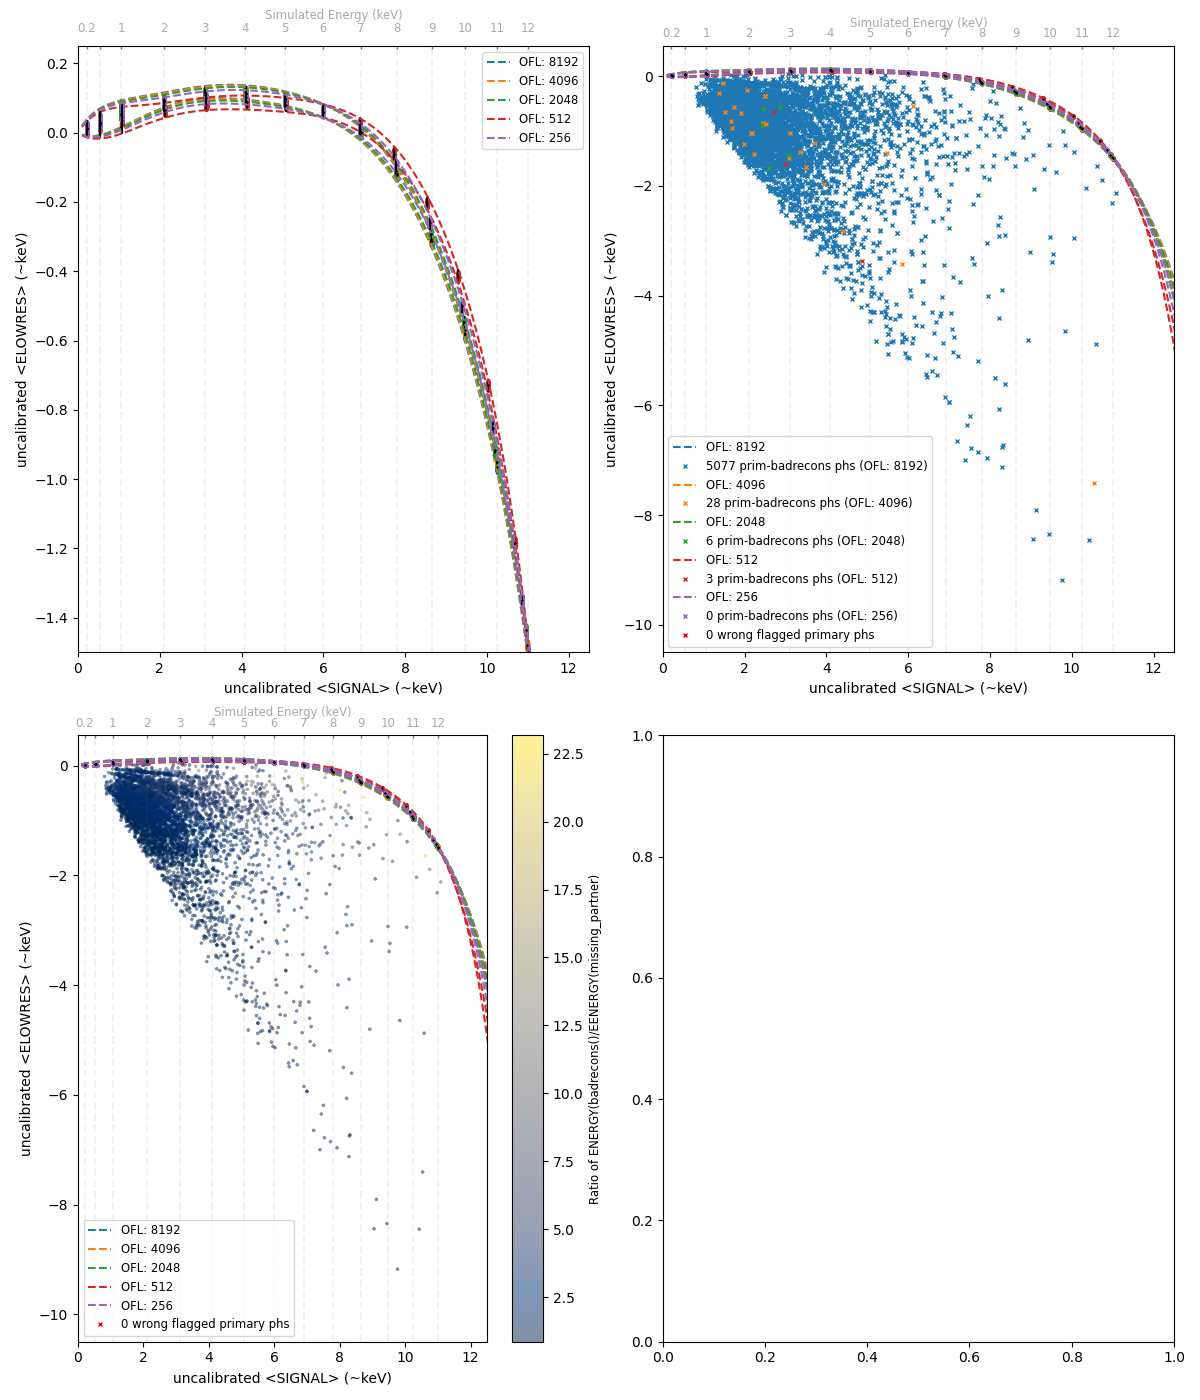

In [28]:
plot_bad_flagged = True #if True, plot the flagged photons

fig, axes = plt.subplots(2, 2, figsize=(12, 14))
(ax1,ax2),(ax3,ax4) = axes
# =================================================
# PLOT 1-TOPL: ELOWRES-SIGNAL vs SIGNAL FOR SINGLES
# =================================================
ax1.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax1.set_ylabel("uncalibrated <ELOWRES> (~keV)")
ax1.set_xlim(0, 12.5)
ax1.set_ylim(-1.5, 0.25)
ytop = ax1.get_ylim()[1]
xtoplot = np.linspace(0.1,13, 100)
# add a top title for the energy values
ax1.text(0.5*ax1.get_xlim()[1], 1.35*ytop, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is equal to ELOWRES (not useful as diagnostic parameter)
    if ofl == 8:
        continue
    points_color = f"C{ifl}"
    for ie in range(len(simEnergies)):
        simE = simEnergies[ie]
        ax1.plot(SIGNAL_mono[ie, ifl], DIFFELOWRES_mono[ie, ifl], marker='.', linestyle='None',markersize=3, color=points_color)
        # plot simulated energy vertical lines (only for first filter length)
        if ifl == 0:
            ax1.axvline(medianSIGNAL[ie, 0], color='gray', linestyle='--', alpha=0.1)
            # add labels where the vertical lines cross the top axis
            if not simEnergies[ie] == 0.5:
                ax1.text(medianSIGNAL[ie, 0], 0.3, simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
            # add also small ticks at the top axis
            ax1.plot(medianSIGNAL[ie, 0], 0.25, alpha=0.5, marker='|', markersize=5,color="black")
        # plot median and the error bars
        ax1.errorbar(medianSIGNAL[ie, ifl], medianDIFFELOWRES[ie,ifl], yerr=nsigmas*stdDIFFELOWRES[ie, ifl], fmt='x', color='black', markersize=1)

    poly_top_plot = poly.polyval(xtoplot, poly_top_coeffs_DIFFELOWRES[ifl])
    poly_bottom_plot = poly.polyval(xtoplot, poly_bottom_coeffs_DIFFELOWRES[ifl])
    ax1.plot(xtoplot, poly_top_plot, linestyle='--', color=points_color, label=f'OFL: {ofl}')
    ax1.plot(xtoplot, poly_bottom_plot, linestyle='--', color=points_color)

ax1.legend(fontsize='small')

# ============================================================
# PLOT 2-TOPR: ELOWRES-SIGNAL vs SIGNAL (SINGLES) & BADRECONS
# ============================================================

ax2.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax2.set_ylabel("uncalibrated <ELOWRES> (~keV)")
ax2.set_xlim(0, 12.5)
ax2.set_ylim(-10.5, 0.55)
ytop = ax2.get_ylim()[1]
xtoplot = np.linspace(0.1,13, 100)
# add a top title for the energy values
ax2.text(0.5*ax1.get_xlim()[1], 1.75*ytop, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

# initialize dictionary for point colors
points_color = {}
for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is equal to ELOWRES (not useful as diagnostic parameter)
    if ofl == 8:
        continue
    points_color[ifl] = f"C{ifl}"
    for ie in range(len(simEnergies)):
        simE = simEnergies[ie]
        ax2.plot(SIGNAL_mono[ie, ifl], DIFFELOWRES_mono[ie, ifl], marker='.', linestyle='None',markersize=3, color=points_color[ifl])
        # plot simulated energy vertical lines (only for first filter length)
        if ifl == 0:
            ax2.axvline(medianSIGNAL[ie, 0], color='gray', linestyle='--', alpha=0.1)
            # add labels where the vertical lines cross the top axis
            if not simEnergies[ie] == 0.5:
                ax2.text(medianSIGNAL[ie, 0], 0.77, simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
            # add also small ticks at the top axis
            ax2.plot(medianSIGNAL[ie, 0], 0.55, alpha=0.5, marker='|', markersize=5,color="black")
        # plot median and the error bars
        ax2.errorbar(medianSIGNAL[ie, ifl], medianDIFFELOWRES[ie,ifl], yerr=nsigmas*stdDIFFELOWRES[ie, ifl], fmt='x', color='black', markersize=1)

    poly_top_plot = poly.polyval(xtoplot, poly_top_coeffs_DIFFELOWRES[ifl])
    poly_bottom_plot = poly.polyval(xtoplot, poly_bottom_coeffs_DIFFELOWRES[ifl])
    ax2.plot(xtoplot, poly_top_plot, linestyle='--', color=points_color[ifl], label=f'OFL: {ofl}')
    ax2.plot(xtoplot, poly_bottom_plot, linestyle='--', color=points_color[ifl])

    # plot all badrecons photons (x marks colored by value of GRADE1)
    indices_to_plot = np.where(all_badrecons_GRADE1 == ofl)
    ax2.plot(all_badrecons_SIGNAL[indices_to_plot], all_badrecons_DIFFELOWRES[indices_to_plot], marker='x', linestyle='None', markersize=3, 
         color=points_color[ifl], label=f'{len(all_badrecons_SIGNAL[indices_to_plot])} prim-badrecons phs (OFL: {ofl})')

# plot bad_flagged photons (red x)
ax2.plot(bad_flagged["SIGNAL"], bad_flagged_DIFFELOWRES, marker='x', linestyle='None', markersize=3, 
             color='red', label=f'{len(bad_flagged["SIGNAL"])} wrong flagged primary phs')
# set legend for the 5-sigma confidence interval
ax2.legend(loc='lower left', fontsize='small')

# ==========================
# PLOT 3-BOTTL: ELOWRES-SIGNAL vs SIGNAL & BADRECONS (BY ENERGY RATIO)
# ==========================
ax3.set_xlabel("uncalibrated <SIGNAL> (~keV)")
ax3.set_ylabel("uncalibrated <ELOWRES> (~keV)")
ax3.set_xlim(0, 12.5)
ax3.set_ylim(-10.5, 0.55)
ytop = ax3.get_ylim()[1]
xtoplot = np.linspace(0.1,13, 100)
# add a top title for the energy values
ax3.text(0.5*ax1.get_xlim()[1], 1.75*ytop, "Simulated Energy (keV)", ha='center', va='center', fontsize='small', color="darkgray")

# initialize dictionary for (singles) point colors
points_color = {}
for ifl in range(len(filtlen_values)):
    ofl = filtlen_values[ifl]
    # skip OFLEN=8 as it is equal to ELOWRES (not useful as diagnostic parameter)
    if ofl == 8:
        continue
    points_color[ifl] = f"C{ifl}"
    for ie in range(len(simEnergies)):
        simE = simEnergies[ie]
        ax3.plot(SIGNAL_mono[ie, ifl], DIFFELOWRES_mono[ie, ifl], marker='.', linestyle='None',markersize=3, color=points_color[ifl])
        # plot simulated energy vertical lines (only for first filter length)
        if ifl == 0:
            ax3.axvline(medianSIGNAL[ie, 0], color='gray', linestyle='--', alpha=0.1)
            # add labels where the vertical lines cross the top axis
            if not simEnergies[ie] == 0.5:
                ax3.text(medianSIGNAL[ie, 0], 0.77, simEnergies_lab[ie], ha='center', va='center', fontsize='small', color="darkgray")
            # add also small ticks at the top axis
            ax3.plot(medianSIGNAL[ie, 0], 0.55, alpha=0.5, marker='|', markersize=5,color="black")
        # plot median and the error bars
        ax3.errorbar(medianSIGNAL[ie, ifl], medianDIFFELOWRES[ie,ifl], yerr=nsigmas*stdDIFFELOWRES[ie, ifl], fmt='x', color='black', markersize=1)

    poly_top_plot = poly.polyval(xtoplot, poly_top_coeffs_DIFFELOWRES[ifl])
    poly_bottom_plot = poly.polyval(xtoplot, poly_bottom_coeffs_DIFFELOWRES[ifl])
    ax3.plot(xtoplot, poly_top_plot, linestyle='--', color=points_color[ifl], label=f'OFL: {ofl}')
    ax3.plot(xtoplot, poly_bottom_plot, linestyle='--', color=points_color[ifl])

# plot all badrecons photons (x marks colored by ratio of ENERGY with its MISSING partner)
ratio_badrecons = np.array(all_badrecons_SIGNAL) / np.array(all_badrecons_MISS0_ENERGY)
norm = mcolors.Normalize(vmin=min(ratio_badrecons), vmax=max(ratio_badrecons))
sc = ax3.scatter(all_badrecons_SIGNAL, all_badrecons_DIFFELOWRES, marker='x', s=3,
            c=ratio_badrecons, cmap='cividis', norm=norm, alpha=0.5)
# plot colorbar
cbar = fig.colorbar(sc, ax=ax3)
cbar.set_label('Ratio of ENERGY(badrecons()/EENERGY(missing_partner)', fontsize='small')


# plot bad_flagged photons (red x)
ax3.plot(bad_flagged["SIGNAL"], bad_flagged_DIFFELOWRES, marker='x', linestyle='None', markersize=3, 
             color='red', label=f'{len(bad_flagged["SIGNAL"])} wrong flagged primary phs')

# set legend for the 5-sigma confidence interval
ax3.legend(loc='lower left', fontsize='small')

fig.tight_layout()

# save the figure to PDF in "Figures" directory
figdir = "Figures"
#fig.savefig(f"{figdir}/flagging_{filter}_{focus}_{flux_mcrab_str}mCrab.png", dpi=300)

In [23]:
# get index where ratio_badrecons is maximum
max_ratio_index = np.argmax(ratio_badrecons)
# get badrecons SIGNAL and missing energy
max_ratio_SIGNAL = all_badrecons_SIGNAL[max_ratio_index]
max_ratio_MISS0_ENERGY = all_badrecons_MISS0_ENERGY[max_ratio_index]
print(f"Maximum ratio of badrecons/missing energy: {max_ratio_SIGNAL:.3f} / {max_ratio_MISS0_ENERGY:.3f} = {ratio_badrecons[max_ratio_index]:.3f}")

Maximum ratio of badrecons/missing energy: 8.013 / 0.346 = 23.172
